# Produce kriging predictions and uncertainty for SIF 

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from cmcrameri import cm

import fields
import model
import prediction
import plot
from data_utils import get_main_coords

%matplotlib inline

In [3]:
ds = xr.open_dataset("../data/exp_pro/OCO2_MODIS_4x5deg_monthly_conus_augmented.nc")
ds = ds.where(ds.time.dt.year > 2014, drop=True)

# Format as multi-fields
ds_sif = ds[["sif", "sif_var", "evi"]]

datasets = [ds_sif]
covariates = [["evi"]]
timedeltas = [0]
vario_config = fields.VarioConfig(1500, 30, n_procs=1)
month_sif = "2016-07-01"

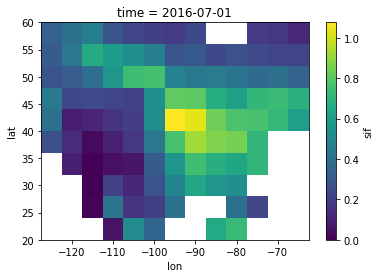

In [4]:
ds_show = get_main_coords(ds_sif.sif.sel(time=month_sif)).sel(time=month_sif)
ds_show.sif.T.plot(vmin=0)

In [5]:
mf = fields.MultiField(
        datasets, covariates, np.datetime64(month_sif), timedeltas
    )
gamma = mf.empirical_variograms(vario_config)

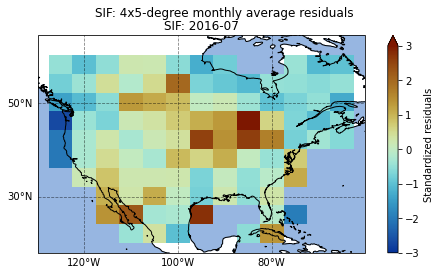

In [6]:
plot.plot_fields(mf, ["SIF"])

## Fitting
---

In [7]:
mod = model.MultivariateMatern(n_procs=1)
mod.fit(gamma)
mod.params.to_dataframe()

,name,value,bounds
0,sigma_11,1.113981,"(0.4, 3.5)"
1,nu_11,0.855851,"(0.2, 3.5)"
2,len_scale_11,672.448792,"(100.0, 2000.0)"
3,nugget_11,0.025305,"(0.0, 0.2)"


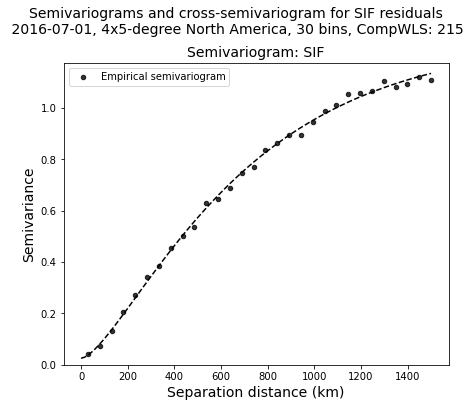

In [8]:
title = "Semivariograms for SIF Residuals, 4x5-Degree Resolution, North America, 2016-07"
plot.plot_variograms(mod.fit_result, ["SIF"], fontsize=14)

## Prediction
---

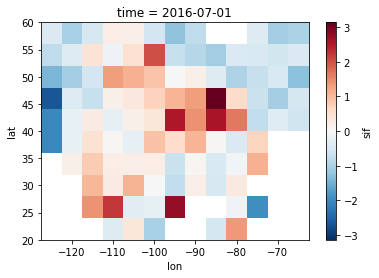

In [9]:
mf.fields[0].ds_main[mf.fields[0].data_name].T.plot()

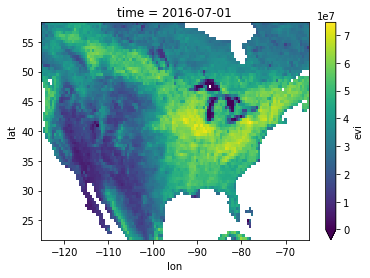

In [10]:
da_evi = xr.open_dataarray("../data/exp_pro/MODIS_05deg_monthly_conus.nc")
da_evi.sel(time=month_sif).T.plot(vmin=0)

In [11]:
pcoords = prediction.prediction_coords()
P = prediction.Predictor(mod, mf, covariates=da_evi)
ds_pred = P(0, pcoords, max_dist=1e3, postprocess=False)
ds_pred

<xarray.Dataset>
Dimensions:   (lon: 121, lat: 73)
Coordinates:
  * lon       (lon) float64 -125.0 -124.5 -124.0 -123.5 ... -66.0 -65.5 -65.0
  * lat       (lat) float64 22.0 22.5 23.0 23.5 24.0 ... 56.5 57.0 57.5 58.0
    time      datetime64[ns] 2016-07-01
Data variables:
    pred      (lon, lat) float64 nan nan nan nan ... -0.8726 -0.9324 -0.9714
    pred_err  (lon, lat) float64 nan nan nan nan ... 0.8657 0.8058 0.7013 0.583

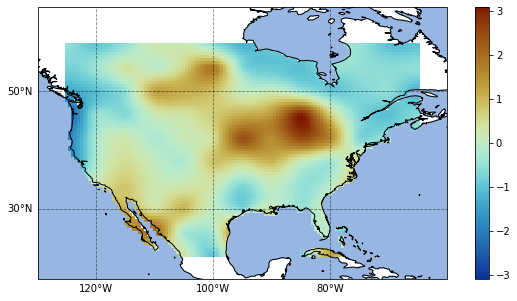

In [12]:
title = f"Kriged Predictions:\nOCO-2 SIF Lite v10r, 0.5-Degree Resolution, Monthly Average {np.datetime_as_string(ds_pred.time, unit='M')}"
units = "SIF 740nm [W/m$^2$/sr/$\mu$m]"
# plot.plot_da(ds_pred.pred, vmin=0, vmax=1, title=title, label=units)
plot.plot_da(ds_pred.pred, cmap=cm.roma_r)

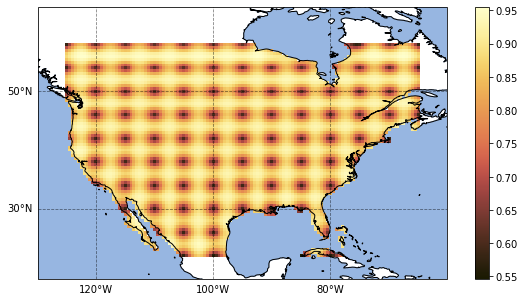

In [13]:
title = f"Kriged Prediction Standard Errors:\nOCO-2 SIF Lite v10r, 0.5-Degree Resolution, Monthly Average {np.datetime_as_string(ds_pred.time, unit='M')}"
units = "SIF 740nm [W/m$^2$/sr/$\mu$m]"
plot.plot_da(ds_pred.pred_err, cmap=cm.lajolla_r)